<a href="https://colab.research.google.com/github/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Item_based_Collaborative_Recommender_System_using_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [114]:
DATASET_LINK='http://files.grouplens.org/datasets/movielens/ml-100k.zip'

In [115]:
!wget -nc http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -n ml-100k.zip

File ‘ml-100k.zip’ already there; not retrieving.

Archive:  ml-100k.zip


## Loading MovieLens dataset

Loading u.info     -- The number of users, items, and ratings in the u data set.

In [116]:
overall_stats = pd.read_csv('ml-100k/u.info', header=None)
print("Details of users, items and ratings involved in the loaded movielens dataset: ",list(overall_stats[0]))

Details of users, items and ratings involved in the loaded movielens dataset:  ['943 users', '1682 items', '100000 ratings']


Loading u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.

---



              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC 

In [117]:
## same item id is same as movie id, item id column is renamed as movie id
column_names1 = ['user id','movie id','rating','timestamp']
dataset = pd.read_csv('ml-100k/u.data', sep='\t',header=None,names=column_names1)
dataset.head() 

,user id,movie id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [118]:
len(dataset), max(dataset['movie id']),min(dataset['movie id'])

(100000, 1682, 1)

Loading u.item     -- Information about the items (movies); this is a tab separated

              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.


In [119]:
d = 'movie id | movie title | release date | video release date | IMDb URL | unknown | Action | Adventure | Animation | Children | Comedy | Crime | Documentary | Drama | Fantasy | Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi | Thriller | War | Western'
column_names2 = d.split(' | ')
column_names2

['movie id',
 'movie title',
 'release date',
 'video release date',
 'IMDb URL',
 'unknown',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [120]:
items_dataset = pd.read_csv('ml-100k/u.item', sep='|',header=None,names=column_names2,encoding='latin-1')
items_dataset

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [121]:
movie_dataset = items_dataset[['movie id','movie title']]
movie_dataset.head()

,movie id,movie title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column

In [122]:
## looking at length of original items_dataset and length of unique combination of rows in items_dataset after removing movie id column
len(items_dataset.groupby(by=column_names2[1:])),len(items_dataset)

(1664, 1682)

We can see there are 18 extra movie id's for already mapped movie title and the same duplicate movie id is assigned to the user in the user-item dataset.

## Merging required datasets

In [123]:
merged_dataset = pd.merge(dataset, movie_dataset, how='inner', on='movie id')
merged_dataset.head()

,user id,movie id,rating,timestamp,movie title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

Example of a multiple rating scenario by an user to a specific movie:

In [124]:
merged_dataset[(merged_dataset['movie title'] == 'Chasing Amy (1997)') & (merged_dataset['user id'] == 894)]

,user id,movie id,rating,timestamp,movie title
4800,894,246,4,882404137,Chasing Amy (1997)
22340,894,268,3,879896041,Chasing Amy (1997)


In [125]:
refined_dataset = merged_dataset.groupby(by=['user id','movie title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


## Exploratory data analysis

*   Plot the counts of each rating
*   Plot rating frequency of each movie

**Plot the counts of each rating**

we first need to get the counts of each rating from ratings data

In [126]:
# num_users = len(refined_dataset.rating.unique())
# num_items = len(refined_dataset.movieId.unique())
num_users = len(refined_dataset['user id'].value_counts())
num_items = len(refined_dataset['movie title'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))


Unique number of users in the dataset: 943
Unique number of movies in the dataset: 1664


In [127]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
1.0,6083
1.5,3
2.0,11334
2.5,6
3.0,27060
3.5,19
4.0,34042
4.5,16
5.0,21130


Text(0, 0.5, 'number of ratings')

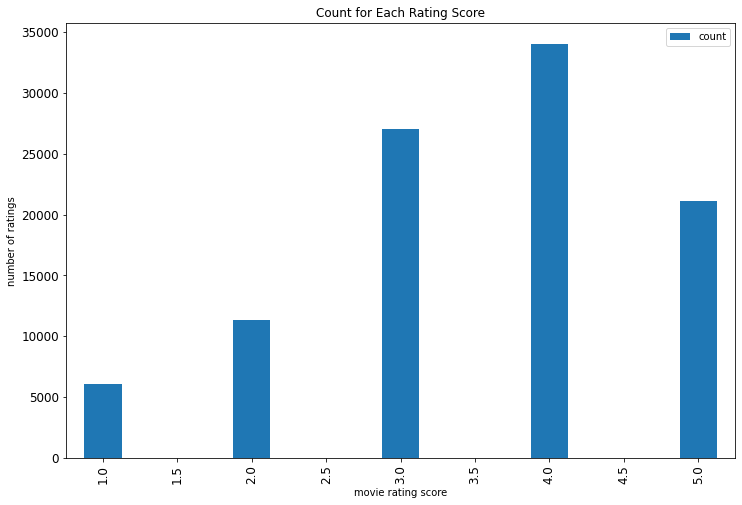

In [128]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

We can see that number of 1.5, 2.5, 3.5, 4.5 ratings by the users are comparitively negligible.

Ratings for the movies not seen by a user is by default considered as 0. Lets calculate and add it to the existing dataframe.

In [129]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

1469459

In [130]:
# append counts of zero rating to df_ratings_cnt
rating_count_df = rating_count_df.append(
    pd.DataFrame({'count': zero_count}, index=[0.0]),
    verify_integrity=True,
).sort_index()
rating_count_df

,count
0.0,1469459
1.0,6083
1.5,3
2.0,11334
2.5,6
3.0,27060
3.5,19
4.0,34042
4.5,16
5.0,21130


Number of times no rating was given (forged as 0 in this case) is a lot more than other ratings.

So let's take log transform for count values and then we can plot them to compare

In [131]:
# add log count
rating_count_df['log_count'] = np.log(rating_count_df['count'])
rating_count_df

,count,log_count
0.0,1469459,14.200405
1.0,6083,8.713253
1.5,3,1.098612
2.0,11334,9.335562
2.5,6,1.791759
3.0,27060,10.205812
3.5,19,2.944439
4.0,34042,10.435350
4.5,16,2.772589
5.0,21130,9.958449


In [132]:
rating_count_df = rating_count_df.reset_index().rename(columns={'index': 'rating score'})
rating_count_df

,rating score,count,log_count
0,0.0,1469459,14.200405
1,1.0,6083,8.713253
2,1.5,3,1.098612
3,2.0,11334,9.335562
4,2.5,6,1.791759
5,3.0,27060,10.205812
6,3.5,19,2.944439
7,4.0,34042,10.435350
8,4.5,16,2.772589
9,5.0,21130,9.958449


Text(0, 0.5, 'number of ratings')

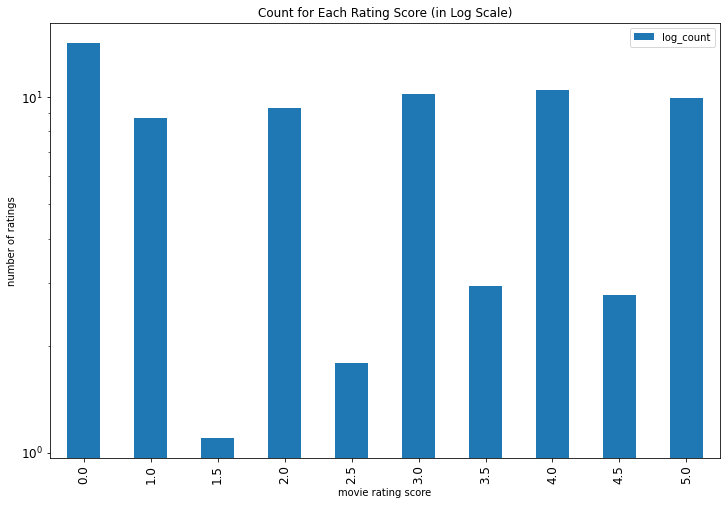

In [133]:
ax = rating_count_df.plot('rating score', 'log_count', 'bar', figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

We have already observed from the before bar plot that ratings 3 and 4 are given in more numbers by the users. Even the above graph suggests the same.

 Take away from this plot is by the number of missing ratings, we can estimate the level of sparsity in the matrix we are going to form. 

**Plot rating frequency of all movies**

In [134]:
refined_dataset.head()

,user id,movie title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


In [135]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('movie title').size(), columns=['count'])
movies_count_df.head()

,count
movie title,
'Til There Was You (1997),9
1-900 (1994),5
101 Dalmatians (1996),109
12 Angry Men (1957),125
187 (1997),41


# Training KNN model to build item-based collaborative Recommender System.

**Reshaping the dataframe**

We need to transform (reshape in this case) the data in such a way that each row of the dataframe represents a movie and each column represents a different user. So we want the data to be [movies, users] array if movie is the subject where similar movies must be found and [users, movies] array for reverse.

To reshape the dataframe, we will pivot the dataframe to the wide format with movies as rows and users as columns. As we know that not all users watch all the movies, we can expect a lot of missing values. We will have to fill those missing observations with 0s since we are going to perform linear algebra operations (calculating distances between vectors). 

Finally, we transform the values of the dataframe into a scipy sparse matrix for most efficient calculations.

This dataframe is then fed into a KNN model.

## Movie Recommendation using KNN with Input as **User id**, Number of similar users should the model pick and Number of movies you want to get recommended:

1. Reshaping model in such a way that each user has n-dimensional rating space where n is total number of movies

 We will train the KNN model inorder to find the closely matching similar users to the user we give as input and we recommend the top movies which would interest the input user.

In [138]:
# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(
    index='user id',
     columns='movie title',
      values='rating').fillna(0)

user_to_movie_df.head()

movie title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


In [139]:
# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<943x1664 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

**Fitting K-Nearest Neighbours model to the scipy sparse matrix:**

In [140]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [141]:
## function to find top n similar users of the given input user 
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]


**Specify User id and Number of similar users we want to consider here**

In [142]:
from pprint import pprint
user_id = 778
print(" Few of movies seen by the User:")
pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

 Few of movies seen by the User:
['Amityville Horror, The (1979)',
 'Angels in the Outfield (1994)',
 'Apocalypse Now (1979)',
 'Apollo 13 (1995)',
 'Austin Powers: International Man of Mystery (1997)',
 'Babe (1995)',
 'Back to the Future (1985)',
 'Blues Brothers, The (1980)',
 'Chasing Amy (1997)',
 'Clerks (1994)']
Top 5 users who are very much similar to the User- 778 are: 
 
1 . User: 124 separated by distance of 0.4586649429539592
2 . User: 933 separated by distance of 0.5581959868865324
3 . User: 56 separated by distance of 0.5858413112292744
4 . User: 738 separated by distance of 0.5916272517988691
5 . User: 653 separated by distance of 0.5991479757406326


**With the help of the KNN model built, we could get desired number of top similar users.**

**Now  picking the top movies to recommend.**

**One way would be by taking the average of the existing ratings given by the similar users and picking the top 10 or 15 movies to recommend to our current user.**


In [143]:
similar_user_list, distance_list

(array([124, 933,  56, 738, 653]),
 array([0.45866494, 0.55819599, 0.58584131, 0.59162725, 0.59914798]))

In [144]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.16419139, 0.19982119, 0.20971757, 0.2117888 , 0.21448105])

Getting ratings of all movies by derived similar users

In [145]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 2., ..., 0., 0., 0.],
       [0., 0., 3., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [146]:
movies_list = user_to_movie_df.columns
movies_list

Index([''Til There Was You (1997)', '1-900 (1994)', '101 Dalmatians (1996)',
       '12 Angry Men (1957)', '187 (1997)', '2 Days in the Valley (1996)',
       '20,000 Leagues Under the Sea (1954)', '2001: A Space Odyssey (1968)',
       '3 Ninjas: High Noon At Mega Mountain (1998)', '39 Steps, The (1935)',
       ...
       'Yankee Zulu (1994)', 'Year of the Horse (1997)', 'You So Crazy (1994)',
       'Young Frankenstein (1974)', 'Young Guns (1988)',
       'Young Guns II (1990)', 'Young Poisoner's Handbook, The (1995)',
       'Zeus and Roxanne (1997)', 'unknown',
       'Á köldum klaka (Cold Fever) (1994)'],
      dtype='object', name='movie title', length=1664)

In [147]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 1664)
Number of movies: 1664


**Broadcasting weightage matrix to similar user rating matrix. so that it gets compatible for matrix operations**

In [148]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 1664)

In [149]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0.        , 0.        , 1.02879509, ..., 0.        , 0.        ,
       0.        ])

In [150]:
from pprint import pprint
def recommend_movies(n):
  n = min(len(mean_rating_list),n)
  # print(np.argsort(mean_rating_list)[::-1][:n])
  pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))



In [151]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Star Wars (1977)',
 'Terminator, The (1984)',
 "Schindler's List (1993)",
 'Fugitive, The (1993)',
 'Forrest Gump (1994)',
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Pulp Fiction (1994)',
 'Die Hard (1988)',
 'Monty Python and the Holy Grail (1974)']


It had been observed that, this recommendation system built can be made more efficient as it has few drawbacks.

**Drawbacks:**

**recommends movies which are already seen by the given input User.**

**movies which are not at all seen by any of the similar users.**



Below function is defined to remove the movies which are already seen the current user and not at all seen by any of the similar users.

In [152]:

def filtered_movie_recommendations(n):
  
  first_zero_index = np.where(mean_rating_list == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_list)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
  filtered_movie_list = list(movies_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    pprint(final_movie_list)


In [153]:
filtered_movie_recommendations(10)

['Star Wars (1977)',
 "Schindler's List (1993)",
 'Princess Bride, The (1987)',
 'Empire Strikes Back, The (1980)',
 'Return of the Jedi (1983)',
 'Fargo (1996)',
 'Dances with Wolves (1990)',
 'Toy Story (1995)',
 'Braveheart (1995)',
 'Star Trek: First Contact (1996)']


Coding up all of the above individual cells into a function.

Giving Input as **User id, Number of similar Users to be considered, Number of top movie we want to recommend**

In [233]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):
  
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user id'] == user_id]['movie title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):
    
    knn_input = np.asarray([user_to_movie_df.values[user-1]])
    
    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)
    
    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


  def filtered_movie_recommendations(n = 10):
  
    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['user id'] == user_id]['movie title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [234]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
307
number of similar users to be considered
15
Enter number of movies to be recommended:
15
Movie seen by the User:
['12 Angry Men (1957)',
 '2001: A Space Odyssey (1968)',
 'Abyss, The (1989)',
 'Alien (1979)',
 'Apollo 13 (1995)',
 'Back to the Future (1985)',
 'Barbarella (1968)',
 'Batman (1989)',
 'Beauty and the Beast (1991)',
 'Blade Runner (1982)',
 'Blues Brothers, The (1980)',
 'Boot, Das (1981)',
 'Brady Bunch Movie, The (1995)',
 'Braveheart (1995)',
 'Brazil (1985)',
 'Casablanca (1942)',
 'Close Shave, A (1995)',
 'Contact (1997)',
 'Crying Game, The (1992)',
 'Dead Poets Society (1989)',
 'Dial M for Murder (1954)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Dragonheart (1996)',
 'E.T. the Extra-Terrestrial (1982)',
 'Empire Strikes Back, The (1980)',
 'English Patient, The (1996)',
 'Englishman Who Went Up a Hill, But Came Down a Mountain, The (1995)',
 'Escape from L.A. (1996)',
 'Fargo (1996)',
 'Fast, Cheap & Out 

## Movie Recommendation using KNN with Input as **Movie Name** and Number of movies you want to get recommended:

2. Reshaping model in such a way that each movie has n-dimensional rating space where n is total number of users who could rate.

 We will train the KNN model inorder to find the closely matching similar movies to the movie we give as input and we recommend the top movies which would more closely align to the movie we have given.

In [157]:
# pivot and create movie-user matrix
movie_to_user_df = refined_dataset.pivot(
     index='movie title',
   columns='user id',
      values='rating').fillna(0)

movie_to_user_df.head()

user id,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
movie title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1-900 (1994),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101 Dalmatians (1996),2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0
12 Angry Men (1957),5.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187 (1997),0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df

<1664x943 sparse matrix of type '<class 'numpy.float64'>'
	with 99693 stored elements in Compressed Sparse Row format>

Extracting movie names into a list:

In [184]:
movies_list = list(movie_to_user_df.index)
movies_list[:10]

["'Til There Was You (1997)",
 '1-900 (1994)',
 '101 Dalmatians (1996)',
 '12 Angry Men (1957)',
 '187 (1997)',
 '2 Days in the Valley (1996)',
 '20,000 Leagues Under the Sea (1954)',
 '2001: A Space Odyssey (1968)',
 '3 Ninjas: High Noon At Mega Mountain (1998)',
 '39 Steps, The (1935)']

Creating a dictionary with movie name as key and its index from the list as value:

In [186]:
movie_dict = {movie : index for index, movie in enumerate(movies_list)}
print(movie_dict)

{"'Til There Was You (1997)": 0, '1-900 (1994)': 1, '101 Dalmatians (1996)': 2, '12 Angry Men (1957)': 3, '187 (1997)': 4, '2 Days in the Valley (1996)': 5, '20,000 Leagues Under the Sea (1954)': 6, '2001: A Space Odyssey (1968)': 7, '3 Ninjas: High Noon At Mega Mountain (1998)': 8, '39 Steps, The (1935)': 9, '8 1/2 (1963)': 10, '8 Heads in a Duffel Bag (1997)': 11, '8 Seconds (1994)': 12, 'A Chef in Love (1996)': 13, 'Above the Rim (1994)': 14, 'Absolute Power (1997)': 15, 'Abyss, The (1989)': 16, 'Ace Ventura: Pet Detective (1994)': 17,.............., 'You So Crazy (1994)': 1656, 'Young Frankenstein (1974)': 1657, 'Young Guns (1988)': 1658, 'Young Guns II (1990)': 1659, "Young Poisoner's Handbook, The (1995)": 1660, 'Zeus and Roxanne (1997)': 1661, 'unknown': 1662, 'Á köldum klaka (Cold Fever) (1994)': 1663}


In [211]:
case_insensitive_movies_list = [i.lower() for i in movies_list]

Fitting a KNN model:

In [159]:
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_sparse_df)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [198]:
## function to find top n similar users of the given input user 
def get_similar_movies(movie, n = 10):
  ## input to this function is the movie and number of top similar movies you want.
  index = movie_dict[movie]
  knn_input = np.asarray([movie_to_user_df.values[index]])
  n = min(len(movies_list)-1,n)
  distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)
  
  print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(movies_list[indices[0][i]])
  


Testing the recommender system with basic input with the movie names


In [199]:
from pprint import pprint
movie_name = '101 Dalmatians (1996)'

get_similar_movies(movie_name,15)

Top 15 movies which are very much similar to the Movie- 101 Dalmatians (1996) are: 
 
Jack (1996)
Twister (1996)
Willy Wonka and the Chocolate Factory (1971)
Independence Day (ID4) (1996)
Toy Story (1995)
Father of the Bride Part II (1995)
Hunchback of Notre Dame, The (1996)
Lion King, The (1994)
Mrs. Doubtfire (1993)
Jungle Book, The (1994)
Grumpier Old Men (1995)
Mission: Impossible (1996)
Mr. Holland's Opus (1995)
Homeward Bound II: Lost in San Francisco (1996)
Dragonheart (1996)


**Dynamically suggesting** movie name from the existing movie corpus we have, based on the user input using try and except architecture.

Defining a function which outputs movie names as suggestion when the user mis spells the movie name. **User might have intended to type any of these movie names.**

In [220]:
# function which takes input and returns suggestions for the user

def get_possible_movies(movie):

    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()

    return possible_movies

This function provides user with **movie name suggestions if movie name is mis-spelled** or **Recommends similar movies to the input movie** if the movie name is valid.

In [223]:
class invalid(Exception):
    pass

def spell_correction():
    
    try:

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      if movie_name_lower not in case_insensitive_movies_list :
        raise invalid
      else :
        # movies_list[case_insensitive_country_names.index(movie_name_lower)]
        num_recom = int(input("Enter Number of movie recommendations needed: "))
        get_similar_movies(movies_list[case_insensitive_movies_list.index(movie_name_lower)],num_recom)

    except invalid:

      possible_movies = get_possible_movies(movie_name_lower)

      if len(possible_movies) == len(movies_list) :
        print("Movie name entered is does not exist in the list ")
      else :
        indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
        print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movies_list[i] for i in indices])
        spell_correction()


In [236]:
spell_correction()

Enter the Movie name: back
Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :
 ['Back to the Future (1985)', 'Backbeat (1993)', 'Best of the Best 3: No Turning Back (1995)', 'Empire Strikes Back, The (1980)', 'Hunchback of Notre Dame, The (1996)', 'Switchback (1997)']
Enter the Movie name: Empire Strikes Back, The (1980)
Enter Number of movie recommendations needed: 15
Top 15 movies which are very much similar to the Movie- Empire Strikes Back, The (1980) are: 
 
Raiders of the Lost Ark (1981)
Indiana Jones and the Last Crusade (1989)
Back to the Future (1985)
Star Wars (1977)
Terminator, The (1984)
Return of the Jedi (1983)
Terminator 2: Judgment Day (1991)
Princess Bride, The (1987)
Jurassic Park (1993)
Fugitive, The (1993)
Silence of the Lambs, The (1991)
E.T. the Extra-Terrestrial (1982)
Star Trek: The Wrath of Khan (1982)
Alien (1979)
Blade Runner (1982)


Observation on above built KNN Recommender System:

An interesting observation would be that the above KNN model for movies recommends movies that are produced in very similar years of the input movie. However, the cosine distance of all those recommendations are observed to be actually quite small. This might be because there are too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart. So I'd like to dig deeper and look closer inside our data.


Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [228]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 93.65% of ratings in our data is missing


This result confirms the above hypothesis. The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

